### Pricing Under Limited Information About the Demand Function
This notebook presents a simulation-based approach to pricing in situations where information about the demand function is limited.
<br/>
The objective is to construct a framework capable of identifying a price that maximizes expected (average) revenue over time.
<br/>
The proposed framework estimates the optimal price using synthetic data.


##### Assumptoins over demand:
- As a modeling simplification, demand is assumed to depend solely on the price \(p\). It is treated as independent of prior price and demand observations ${(P_1, D_1), ..., (P_{n-1}, D_{n-1})}$.
- For all $p \in P$, the probability distribution of $D(p)$ is assumed to be light-tailed.
- Demand is modeled using a Poisson distribution based on the following considerations:
  1. Demand represents counts of discrete events (e.g., purchases, arrivals, or orders).  
  2. Events are assumed to occur randomly over time.  
  3. Events are assumed to occur independently.  
  4. The expected event rate $\lambda$ is assumed constant within the observation period.  
  5. The variance of demand is assumed equal to its mean, consistent with Poisson properties.


##### Demand data simulation
- We assume the availability of historical demand data covering a three-month period (90 days), during which each price level was applied for a duration of 15 days.
- Price levels are generated randomly, and the observed sales quantities are simulated using the true demand function.
- A scaling term is introduced to control variability and mitigate the impact of stochastic noise inherent in the Poisson process.

##### Intuition on process:
1) Select a demand function D(p) to represent the relationship between price and demand. The choice should be guided by domain knowledge and empirical considerations.
2) Consider a set $A$ set of functions {$d_1, d_2, ...d_n$} that share the same functional form as $D(p)$. The mean function of this set can be used as a minimum-variance estimator for $D(p)$.
3) Use historical data to estimate the parameters of the demand model and derive confidence intervals for these parameters
4) Generate the functions in set $A$ by sampling parameters within the estimated confidence intervals.
5) Simulate a broad range of demand scenarios using the functions in set $A$.
6) Compute the average revenue associated with each price level across the simulated scenarios.
7) Identify the price that maximizes the expected (average) revenue and select it as the pricing decision.

In [27]:
import gc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [28]:
rng = np.random.default_rng(42)

def plot_demand_and_price(df, group_by_price=False, title=""):
    
    if group_by_price:
        df_plot = df.groupby('price_index').agg({
            'demand': 'sum',
            'price': 'mean'
        })

        df_plot['t'] = df_plot.index
        x_label = 'Pricing Campaign'
    else:
        df_plot = df
        x_label = 'Time'
    
    fig, ax1 = plt.subplots()

    ax1.plot(df_plot.t, df_plot.demand, color='blue')
    ax1.set_ylabel('Demand (#)', color='blue')
    ax1.set_xlabel(x_label)

    ax2 = ax1.twinx()
    ax2.plot(df_plot.t, df_plot.price, color='red')
    ax2.set_ylabel('Price ($)', color='red')

    plt.title('Demand and Price Over Time')
    plt.show()

    return fig, ax1

def plot_revenue_and_price(df, time_index, group_by_price=False):
    if group_by_price:
        df_plot = df.groupby('price_index').agg({
            'revenue': 'sum',
            'price': 'mean'
        })

        df_plot['t'] = df_plot.index
        x_label = 'Pricing Campaign'
    else:
        df_plot = df
        x_label = 'Time'
    
    
    fig, ax1 = plt.subplots()

    ax1.plot(df_plot.t, df_plot.revenue, color='blue')
    ax1.set_ylabel('Revenue ($)', color='blue')
    ax1.set_xlabel(x_label)

    if time_index > 0:
        ax1.axvline(time_index, linewidth=2, color='black', linestyle='--') 
    
    ax2 = ax1.twinx()
    ax2.plot(df_plot.t, df_plot.price, color='red')
    ax2.set_ylabel('Price ($)', color='red')

    plt.title('Revenue Given Price Over Time')
    plt.show()
    
    return fig, ax1

### 1) Historical Data Simulation

- The demand function is defined as a Poisson process with mean:
$$
\lambda = 1350 * e^(-0.05 * p_t)
$$
- Prices are randomly generated on a range of [10, 30]

In [29]:
def true_demand(p): return 1350 * np.exp(-0.05 * p)

def get_sales(p, noise_scale=0.5):
    mean = true_demand(p)
    return rng.poisson(mean * noise_scale) / noise_scale

month_prices = rng.choice(30 - 10, size=6, replace=False) + 10 # Unique prices
prices =  [int(p) for p in month_prices for i in range(15)]
demand = [get_sales(p) for p in prices]

df = pd.DataFrame({
    't': np.arange(len(prices)),
    'price': prices,
    'demand': demand
})

df['price_index'] = (df['t'].astype(int) // 15)
df['revenue'] = df['price'] * df['demand']
print(df.shape)
df.head()

(90, 5)


,t,price,demand,price_index,revenue
0,0,21,498.0,0,10458.0
1,1,21,432.0,0,9072.0
2,2,21,460.0,0,9660.0
3,3,21,486.0,0,10206.0
4,4,21,468.0,0,9828.0


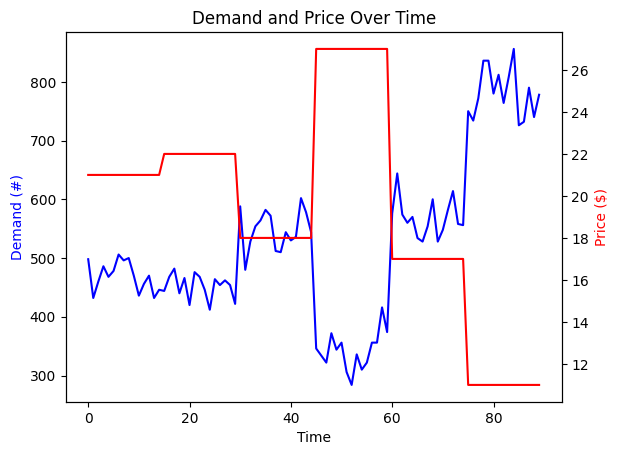

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='Time', ylabel='Demand (#)'>)

In [30]:
plot_demand_and_price(df)

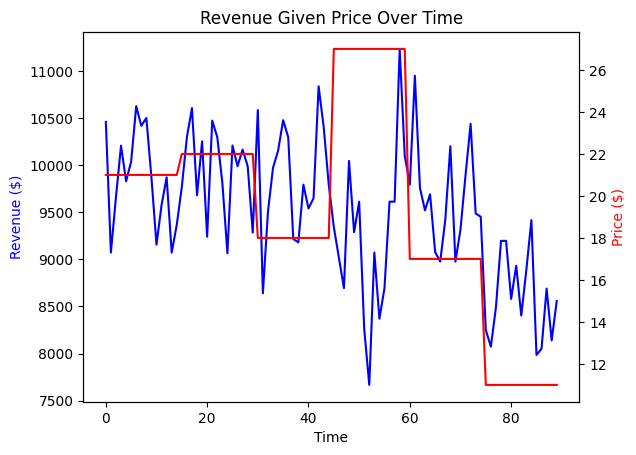

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Time', ylabel='Revenue ($)'>)

In [31]:
plot_revenue_and_price(df, 0)

### 2) Parameter estimation
Because sales are count data generated by a Poisson process, the Poisson GLM is the correct statistical model.

In this setting, demand is modeled as

$$
\mathbb{E}[D \mid p] = a \, e^{-e p}
$$

which implies a log link between expected demand and price. A Poisson GLM with a log link matches this structure exactly, ensuring that predictions are non-negative, the mean–variance relationship (variance proportional to the mean) is respected, and parameter estimates are unbiased and consistent.


In [32]:
X = sm.add_constant(df["price"].values)
y = df["demand"].values

poisson_model = sm.GLM(
    y,
    X,
    family=sm.families.Poisson(link=sm.families.links.log())
)

res = poisson_model.fit()
res.summary()

c:\Users\BRENO\Documents\Pricing Example\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:                            GLM   Df Residuals:                       88
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -444.60
Date:                Wed, 11 Feb 2026   Deviance:                       162.78
Time:                        21:36:19   Pearson chi2:                     163.
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2200      0.017    416.713      0.000       7.186       7.254
x1            -0.0509      0.001    -55.142      0.000      -0.053      -0.049
==============================================================================
"""

The GLM results suggest that the Poisson model with a log link fits the data well. The price coefficient $(x1 = -0.0509)$ is negative and statistically significant $(p < 0.001)$, indicating that demand decreases as price increases. The coefficient implies that a one-unit increase in price reduces expected demand by roughly 5%.

The intercept (const = 7.22) represents baseline log-demand at zero price, corresponding to 
$exp(7.22)$. The high pseudo $R^2 (≈ 1.0)$ is expected given that the data were simulated from a compatible functional form. Deviance and Pearson statistics are consistent with the Poisson assumption.

### 3) Generate the set A

In [33]:
confidence_intervals = res.conf_int()

# C.I. for elasticity
e_ci = confidence_intervals[1]

# C.I. for a
log_a_ci = confidence_intervals[0]
a_ci = np.exp(log_a_ci)

demand_searchspace = []

for i in range(0, 101):
    a = rng.integers(low=np.floor(a_ci[0]), high=np.ceil(a_ci[1]))
    elasticity = rng.uniform(low=e_ci[0], high=e_ci[1])

    def d(p, a=a, e=elasticity):
        return float(np.ceil(a * np.exp(e * p)))

    demand_searchspace.append(d)

### 4) Simulation
- The set of functions is used to simulate demand responses for a given price.
- The objective is to identify the price that maximizes expected (average) revenue.
- The mean demand function derived from set $A$ is treated as an approximation of the true demand function.


In [34]:
# del demand
# del prices 
# gc.collect()

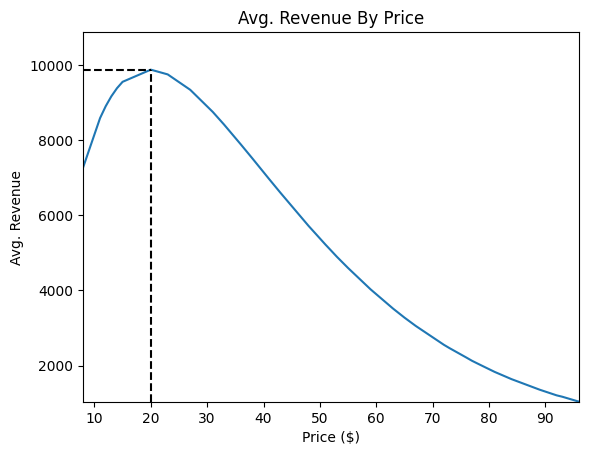

In [35]:
simulation_prices = rng.integers(0, 100, 50)
demand = []
prices = []

for i in range(len(demand_searchspace)):
    x = [demand_searchspace[i](p) for p in simulation_prices for j in range(15)]
    p = [int(p) for p in simulation_prices for j in range(15)]

    demand.extend(x)
    prices.extend(p)

df_simulation = pd.DataFrame({
    't': np.arange(len(prices)),
    'price': prices,
    'demand': demand
})

df_simulation['revenue'] = df_simulation['price'] * df_simulation['demand']
df_plot = df_simulation.groupby('price')['revenue'].mean().reset_index()
df_plot.sort_values(by='price', inplace=True)

i = np.argmax(df_plot['revenue'])
opt_price = df_plot.iloc[i].price
opt_rev = df_plot.iloc[i].revenue

plt.plot(df_plot.price, df_plot.revenue)
plt.hlines(opt_rev, df_plot['price'].min(), opt_price, color='black', linestyles='dashed')
plt.vlines(opt_price, df_plot['revenue'].min(), opt_rev, color='black', linestyles='dashed')

plt.xlim(df_plot['price'].min(), df_plot['price'].max())
plt.ylim(df_plot['revenue'].min(), df_plot['revenue'].max() + 1000)

plt.xlabel('Price ($)')
plt.ylabel('Avg. Revenue')
plt.title('Avg. Revenue By Price')
plt.show()

### Conclusion

Based on the proposed simulation framework, the pricing strategy was evaluated under uncertainty in the demand function. By generating a set of plausible demand curves consistent with the assumed functional form and parameter variability, a broad range of demand scenarios was examined.
<br/>
For each candidate price, revenue was computed across simulated demand realizations, and the expected (average) revenue was used as the decision criterion. Under the modeling assumptions and simulated data, the price that maximized expected revenue was 20.
<br/>
This result should be interpreted within the limits of the adopted assumptions, particularly the choice of demand functional form, the parameter distributions, and the Poisson demand model. In practical applications, the framework can be refined by incorporating richer demand drivers, relaxing distributional assumptions, and validating parameter uncertainty with real data.
